In [2]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# Download Data

In [3]:
# mutation data
df_raw = pd.read_csv('/Users/kimrants/PycharmProjects/thesis_code/Thesis_code/gbm-mutations/Data/TCGA.GBM.mutect.somaticgene_matrix.csv')

# Survival data
df_raw_survival = pd.read_csv('/Users/kimrants/PycharmProjects/thesis_code/Thesis_code/gbm-mutations/Data/tcga_survival_data.csv')

# Display and inspect data

In [4]:
df_raw.info()
print(df_raw.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17107 entries, 0 to 17106
Columns: 394 entries, mutation to TCGA-RR-A6KC
dtypes: int64(393), object(1)
memory usage: 51.4+ MB
  mutation  TCGA-02-0003  TCGA-02-0033  TCGA-02-0047  TCGA-02-0055  \
0    POSTN             0             0             0             0   
1    LUZP2             0             0             0             0   
2   KLHDC1             0             0             0             0   
3     EPC1             0             0             0             0   
4   UBXN2A             0             0             0             0   

   TCGA-02-2466  TCGA-02-2470  TCGA-02-2483  TCGA-02-2485  TCGA-02-2486  \
0             0             0             0             0             0   
1             0             0             0             0             0   
2             0             0             0             0             0   
3             0             0             0             0             0   
4             0             

### Notice: currently columns = persons, rows = Genes mutated in GBM
## Transpose Data and fix header for DF

In [17]:
# Transpose the data
df = df_raw.transpose()

new_header = df.iloc[0] #grab the first row for the header
df = df[1:] #take the data less the header row
df.columns = new_header #set the header row as the df header
print(df.shape)
print(df.head())

(393, 17107)
mutation     POSTN LUZP2 KLHDC1 EPC1 UBXN2A SAP30 RSU1P2 ZSCAN20 MTX1 FANCB  \
TCGA-02-0003     0     0      0    0      0     0      0       0    0     0   
TCGA-02-0033     0     0      0    0      0     0      0       0    0     0   
TCGA-02-0047     0     0      0    0      0     0      0       0    0     0   
TCGA-02-0055     0     0      0    0      0     0      0       0    0     0   
TCGA-02-2466     0     0      0    0      0     0      0       0    0     0   

mutation     ...  RPL22P19 GPATCH3 GRM7 SYCE1 ERCC1 KIAA0232 CACFD1 EGFL7  \
TCGA-02-0003 ...         0       0    0     0     0        0      0     0   
TCGA-02-0033 ...         0       0    0     0     0        0      0     1   
TCGA-02-0047 ...         0       0    0     0     0        0      0     0   
TCGA-02-0055 ...         0       0    0     0     0        0      0     0   
TCGA-02-2466 ...         0       0    0     0     0        0      0     0   

mutation     GPD1 MCAM  
TCGA-02-0003    0    0  

### Now we have persons as rows. Each cell is binary: 0 for no mutation, and 1 for a mutation

## Now: Descriptive stats (primary vs. secondary)
Primary tumours have no mutations in the IDH1 gene, whereas secondary tumours do.

Primary: 370
Secondary: 23


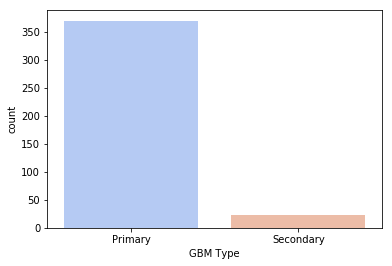

In [159]:
#idh1_mutations_list = df['IDH1']
df['GBM Type'] = df.apply(
    lambda row: 'Primary' if (row['IDH1']==0) else 'Secondary',
    axis=1
)

prim_sec_list = df['GBM Type'].tolist()

df_idh1 = pd.DataFrame(columns=['GBM Type'], data=prim_sec_list)

# How to create a fucking countPlot
sns.countplot(x='GBM Type',
              data=df_idh1,
              palette='coolwarm'
             )

print("Primary:", df_idh1['GBM Type'].tolist().count('Primary'))
print("Secondary:", df_idh1['GBM Type'].tolist().count('Secondary'))


## Survival Data

In [6]:
df_survival = df_raw_survival.set_index('submitter_id') # set index (i.e. row)
print(df_survival.shape)

# Only use rows that does not include NaN --> Drop NaN
df_survival = df_survival.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)
print(df_survival.shape)

(617, 2)
(562, 2)


# Q: How to deal with "dead/alive"? Only use subjects that are dead?

In [7]:
# For now, only keep subjects that are "dead"
df_survival = df_survival[df_survival.vital_status != 'alive']
print(df_survival.shape)

(460, 2)


# Visualise the data, i.e. "ground truth"

In [8]:
# Check that type of survival time is float
print(df_survival.iloc[0][0].dtype)

# Remove the "vital status" column
df_survival.drop(['vital_status'], axis=1)

float64


days_to_last_follow_up
submitter_id                        
TCGA-14-1034                   485.0
TCGA-08-0518                    39.0
TCGA-41-3392                    30.0
TCGA-06-0152                   359.0
TCGA-12-3644                  1807.0
TCGA-76-4935                   328.0
TCGA-19-1789                    99.0
TCGA-06-6693                    15.0
TCGA-08-0350                   104.0
TCGA-08-0517                  1770.0
TCGA-02-0023                   612.0
TCGA-02-0025                  1300.0
TCGA-08-0510                   107.0
TCGA-02-0027                   315.0
TCGA-06-2566                   182.0
TCGA-06-0394                   314.0
TCGA-06-0882                   165.0
TCGA-27-1834                  1008.0
TCGA-06-0210                   151.0
TCGA-02-0043                   557.0
TCGA-06-2567                   133.0
TCGA-12-5299                    98.0
TCGA-02-0084                     7.0
TCGA-14-0871                   880.0
TCGA-02-0432                  1433.0
TCGA-12-0772                  1615.0
TCGA-19-5951                   244.0
TCGA-12-1094                   346.0
TCGA-12-1093                   364.0
TCGA-02-0054                   199.0
...                              ...
TCGA-27-2519                   316.0
TCGA-02-0037                   110.0
TCGA-06-0216                   684.0
TCGA-06-0686                   286.0
TCGA-08-0385                    31.0
TCGA-06-0237                   315.0
TCGA-76-6193                    82.0
TCGA-08-0244                   690.0
TCGA-19-5954                   242.0
TCGA-06-0649                    62.0
TCGA-02-0034                   430.0
TCGA-06-0644                   375.0
TCGA-02-0104                  1977.0
TCGA-12-1091                   929.0
TCGA-76-4925                   146.0
TCGA-19-2624                     5.0
TCGA-27-2521                   316.0
TCGA-27-1838                   350.0
TCGA-02-0086                   268.0
TCGA-06-0192                   557.0
TCGA-27-1837                   427.0
TCGA-32-2616                   224.0
TCGA-41-2575                   290.0
TCGA-12-0778                   452.0
TCGA-76-4931                   279.0
TCGA-12-0819                   754.0
TCGA-19-5955                    54.0
TCGA-76-6192                   100.0
TCGA-32-5222                   323.0
TCGA-32-1973                   641.0

[460 rows x 1 columns]

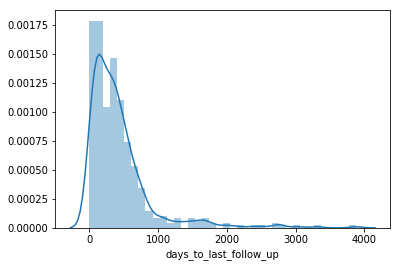

In [9]:
# Plot survival to get sense of data
sns.distplot(df_survival.days_to_last_follow_up)

# Random Forrest

In [10]:
# Just to test that "join" works right --> it does :)
df_survival.loc['TCGA-02-2466']

days_to_last_follow_up     511
vital_status              dead
Name: TCGA-02-2466, dtype: object

In [11]:
# Identify matches
rf_data = df.join(df_survival)

# Drop where there is not match, leaves 275
rf_data = rf_data.dropna()
rf_data.head()

print(rf_data.shape)

(275, 17109)


In [12]:
# Independent and dependent variables
X = rf_data.drop(['days_to_last_follow_up', 'vital_status'], axis=1)
Y = rf_data['days_to_last_follow_up']

# Split data into training and test data
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

# Train Model
rfr = RandomForestRegressor(n_estimators=50, max_depth=None) # rfr= randomForrestRegressor
rfr.fit(x_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [13]:
# Get predictions
rfr_prediction = rfr.predict(x_test)
rfr_prediction

array([ 210.48,  182.34,  774.52,  391.44,  267.08,  186.88,  267.96,
        214.78,  139.54,  343.22,  221.58,  170.48,  397.78,  189.3 ,
        151.08,  291.08,  200.88,  270.04,  211.54,  140.02,  367.12,
        166.08,  264.28,  380.28,  191.32,  240.02,  273.08,  214.16,
       1184.28,  236.  ,  286.1 ,  249.76,  298.9 ,  130.82,  514.68,
        356.44,  281.1 ,  217.66,  204.8 ,  311.04,  148.74,  149.98,
        654.2 ,  238.16,  130.82,  662.36,  210.04,  181.14,  296.48,
        201.64,  251.48,  282.02,  264.3 ,  171.4 ,  719.14,  229.94,
        266.22,  273.28,  257.16,  334.4 ,  124.18,  281.78,  211.3 ,
        218.62,  204.52,  804.12,  225.84,  198.32,  221.44,  177.96,
        196.8 ,  214.32,  155.04,  222.7 ,  213.48,  172.52,  147.46,
        344.7 ,  190.64,  473.34,  263.22,  241.94,  148.68])

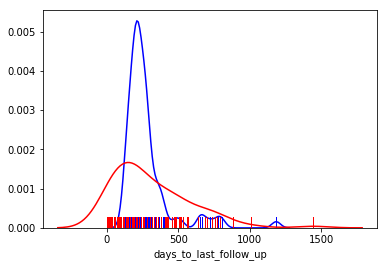

In [14]:
#Visualise predictions against reality
sns.distplot(rfr_prediction, hist=False, rug=True, color='blue')
sns.distplot(y_test, hist=False, rug=True, color='red')

# Feature selection
## Q: When feature selecting, do I need to do test-split? Can't I just train on all of the data and then select the best features?

In [15]:
# "feature_names" was set further up
feature_names = new_header
print("Features sorted by their score:")
print(sorted(zip(map(lambda x: round(x, 4), rfr.feature_importances_), feature_names), 
             reverse=True)) 


Features sorted by their score:
[(0.099, 'NES'), (0.082, 'SORBS1'), (0.0495, 'TRAPPC10'), (0.0318, 'TBCE'), (0.0286, 'TRMU'), (0.019, 'PHKA2'), (0.019, 'MAP3K13'), (0.0182, 'MFSD9'), (0.0174, 'LAMC2'), (0.0174, 'C2orf42'), (0.0142, 'R3HDM1'), (0.0139, 'TMOD2'), (0.0134, 'CHMP2B'), (0.0109, 'TRIM69'), (0.0109, 'SYK'), (0.0109, 'FASN'), (0.0106, 'YARS'), (0.0094, 'SPRED2'), (0.0094, 'CR1L'), (0.0089, 'MCM5'), (0.0088, 'PTPN4'), (0.0083, 'SLIT1'), (0.0079, 'TMEM26'), (0.0079, 'NBPF3'), (0.0076, 'HDX'), (0.0075, 'DNASE2'), (0.0075, 'ADHFE1'), (0.0071, 'GLDC'), (0.007, 'HDAC1'), (0.0068, 'NPHS1'), (0.0067, 'FAM193A'), (0.0065, 'PSMD12'), (0.0065, 'MUC2'), (0.0056, 'GSG2'), (0.0055, 'TROAP'), (0.0054, 'HDAC5'), (0.0051, 'PCDHA12'), (0.005, 'FBXO27'), (0.0048, 'CACNA2D3'), (0.0046, 'CADPS'), (0.0044, 'ANO7'), (0.0043, 'ITGAM'), (0.0041, 'CCBL2'), (0.0038, 'NLRP7'), (0.0038, 'IDH1'), (0.0037, 'GTF3C4'), (0.0035, 'ALG10B'), (0.0034, 'STARD10'), (0.0033, 'BMP3'), (0.003, 'CPT1A'), (0.0029, 'FANC

In [16]:
print("Top 10 features")
print(sorted(zip(map(lambda x: round(x, 4), rfr.feature_importances_), feature_names), 
             reverse=True)[:10]) 

Top 10 features
[(0.099, 'NES'), (0.082, 'SORBS1'), (0.0495, 'TRAPPC10'), (0.0318, 'TBCE'), (0.0286, 'TRMU'), (0.019, 'PHKA2'), (0.019, 'MAP3K13'), (0.0182, 'MFSD9'), (0.0174, 'LAMC2'), (0.0174, 'C2orf42')]
